In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [2]:
# Cell 1: Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

print("All libraries imported successfully.")
print("TensorFlow Version:", tf.__version__)

2025-08-22 19:39:02.864783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755891543.069880      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755891543.130619      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully.
TensorFlow Version: 2.18.0


In [3]:
import os
# This will hide INFO and WARNING messages.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
# ... rest of your imports and code

In [4]:
# Cell 2: Define constants and the loading function
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
# The path is specific to the Kaggle environment
DATA_PATH = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'

def load_data(data_path):
    images = []
    masks = []
    # We only need to read directories, not the 'data.csv' or 'README.md'
    patient_folders = [f for f in os.listdir(data_path) if not f.endswith(('.csv', '.md'))]
    
    for patient_folder in patient_folders:
        patient_path = os.path.join(data_path, patient_folder)
        image_files = [f for f in os.listdir(patient_path) if '_mask' not in f]
        
        for image_file in image_files:
            mask_file = image_file.replace('.tif', '_mask.tif')
            if os.path.exists(os.path.join(patient_path, mask_file)):
                img = cv2.imread(os.path.join(patient_path, image_file))
                img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
                images.append(img)
                
                mask = cv2.imread(os.path.join(patient_path, mask_file), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
                masks.append(mask)

    return np.array(images), np.array(masks)

# Load the data
X, y = load_data(DATA_PATH)

# Normalize the data
X = X / 255.0
y = y / 255.0  # Masks are 0 or 255, this makes them 0 or 1
y = np.expand_dims(y, axis=-1) # Add a channel dimension for the model

print(f"Data loaded successfully. Number of images: {len(X)}")
print(f"Image shape: {X.shape}")
print(f"Mask shape: {y.shape}")

Data loaded successfully. Number of images: 3929
Image shape: (3929, 128, 128, 3)
Mask shape: (3929, 128, 128, 1)


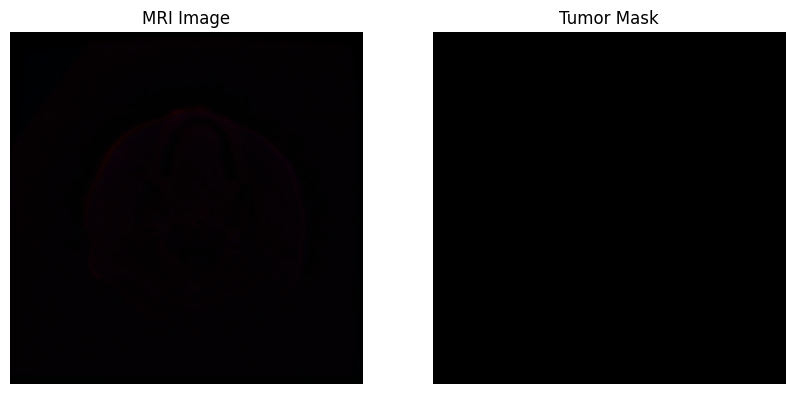

In [5]:
# Cell 3: Visualize a Sample
import random
import matplotlib.pyplot as plt

# Select a random index from the dataset
sample_index = random.randint(0, len(X) - 1)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the original MRI image
ax[0].imshow(X[sample_index])
ax[0].set_title('MRI Image')
ax[0].axis('off')

# Display the corresponding tumor mask
# np.squeeze removes the single channel dimension (e.g., (128, 128, 1) -> (128, 128)) for grayscale display
ax[1].imshow(np.squeeze(y[sample_index]), cmap='gray')
ax[1].set_title('Tumor Mask')
ax[1].axis('off')

plt.show()

In [6]:
# Cell 4: Split the Data
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
# test_size=0.2 means 20% of the data will be used for validation
# random_state=42 ensures that the split is the same every time you run the code
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets to confirm the split
print(f"Training data shape: {X_train.shape}")
print(f"Training masks shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation masks shape: {y_val.shape}")

Training data shape: (3143, 128, 128, 3)
Training masks shape: (3143, 128, 128, 1)
Validation data shape: (786, 128, 128, 3)
Validation masks shape: (786, 128, 128, 1)


In [7]:
# Cell 5: Define the U-Net Model Architecture
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout

def build_unet(input_shape):
    inputs = Input(input_shape)

    # --- Encoder (Contracting Path) ---
    # Block 1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Block 3
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # --- Bottleneck ---
    b = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    b = Dropout(0.3)(b)
    b = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(b)

    # --- Decoder (Expansive Path) ---
    # Block 6
    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(b)
    u6 = concatenate([u6, c3]) # Skip connection
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Block 7
    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2]) # Skip connection
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Block 8
    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1]) # Skip connection
    c8 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # --- Output Layer ---
    # The sigmoid activation function outputs values between 0 and 1, perfect for a binary mask.
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build the model and print its summary
model = build_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.summary()

I0000 00:00:1755891620.232516      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755891620.233235      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     32,832 │ conv2d_7[0][0]  

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Cell 6: Define Loss Function and Metrics
import tensorflow as tf

# The Dice Coefficient is a common metric for image segmentation
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# The Dice Loss is 1 minus the Dice Coefficient
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

print("Dice loss and coefficient functions defined.")

Dice loss and coefficient functions defined.


In [9]:
# Cell 7: Compile and Train
model = build_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) # Assumes build_unet is defined in a previous cell
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coefficient])

# Define callbacks
callbacks = [
    # Save the model to the Kaggle working directory
    tf.keras.callbacks.ModelCheckpoint('/kaggle/working/tumor_segmentation.h5', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

# This will take some time, but it will be much faster with the GPU!

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)
I0000 00:00:1755891633.284877      62 service.cc:148] XLA service 0x78fc600406a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755891633.285498      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755891633.285519      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755891634.201004      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/197 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - dice_coefficient: 0.0103 - loss: 0.9897

I0000 00:00:1755891645.686069      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coefficient: 0.0263 - loss: 0.9737
Epoch 1: val_loss improved from inf to 0.97873, saving model to /kaggle/working/tumor_segmentation.h5
197/197 ━━━━━━━━━━━━━━━━━━━━ 43s 111ms/step - dice_coefficient: 0.0263 - loss: 0.9737 - val_dice_coefficient: 0.0217 - val_loss: 0.9787
Epoch 2/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - dice_coefficient: 0.0522 - loss: 0.9478
Epoch 2: val_loss improved from 0.97873 to 0.60921, saving model to /kaggle/working/tumor_segmentation.h5
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - dice_coefficient: 0.0526 - loss: 0.9474 - val_dice_coefficient: 0.3926 - val_loss: 0.6092
Epoch 3/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - dice_coefficient: 0.4343 - loss: 0.5657
Epoch 3: val_loss improved from 0.60921 to 0.55960, saving model to /kaggle/working/tumor_segmentation.h5
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - dice_coefficient: 0.4344 - loss: 0.5656 - val_dice_coefficient: 0.4472 - val_loss: 0.5596
Epoch 4/

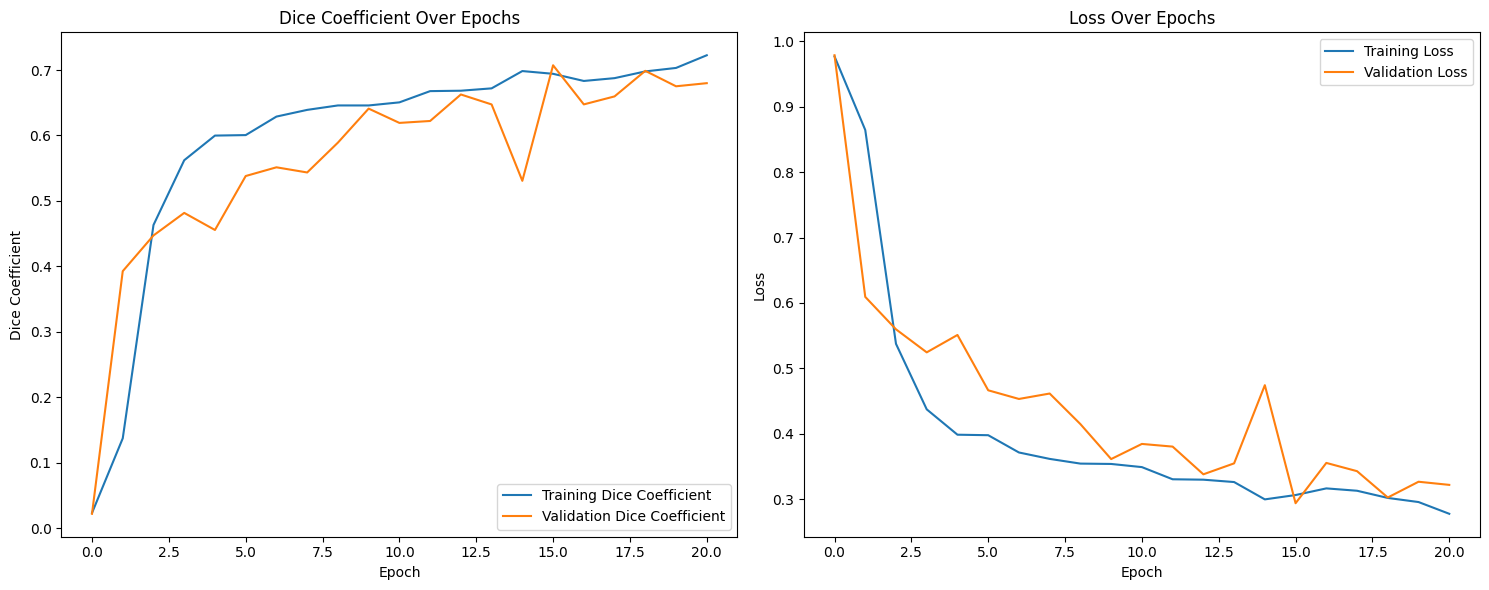

In [10]:
# Cell 8: Evaluate the Model (Plotting History)
import matplotlib.pyplot as plt

# Create a figure with two subplots: one for the Dice Coefficient and one for the Loss
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# --- Plot 1: Dice Coefficient ---
ax[0].plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
ax[0].plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
ax[0].set_title('Dice Coefficient Over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Dice Coefficient')
ax[0].legend(loc='lower right')

# --- Plot 2: Loss ---
ax[1].plot(history.history['loss'], label='Training Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss Over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right')

# Adjust the layout to prevent titles from overlapping
plt.tight_layout()

# Display the plots
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


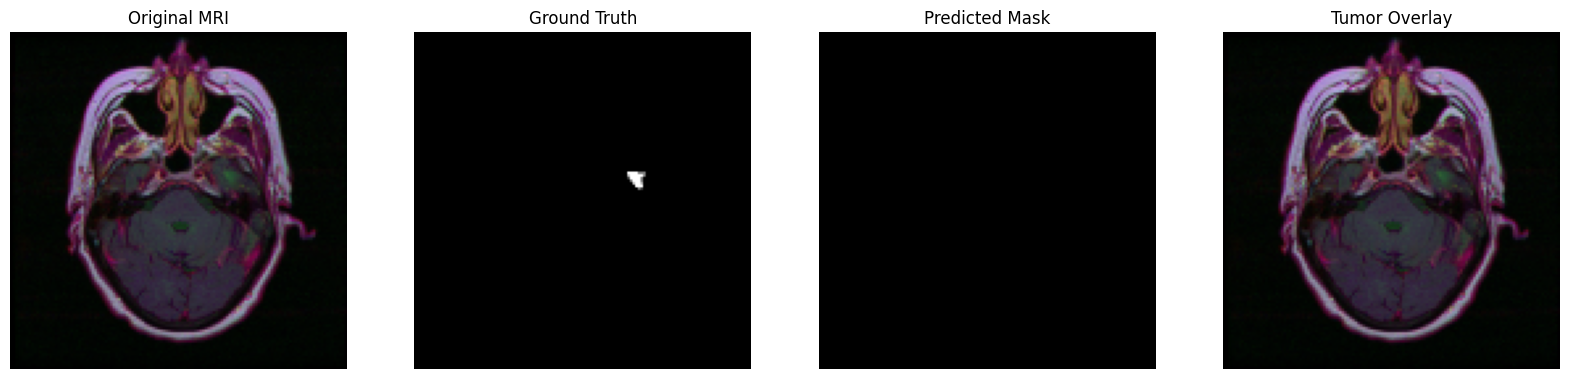

In [11]:
# Cell 9: Inference and Visualization
import random

# Load the best saved model from the working directory
model.load_weights('/kaggle/working/tumor_segmentation.h5')

# Select a random sample from the validation set
test_index = random.randint(0, len(X_val) - 1)
test_image = X_val[test_index]
ground_truth_mask = y_val[test_index]

# Predict
test_image_input = np.expand_dims(test_image, axis=0)
predicted_mask = model.predict(test_image_input)[0]
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Visualization (this code is the same as before)
original_image_display = (test_image * 255).astype(np.uint8)
colored_mask = cv2.cvtColor(np.squeeze(predicted_mask_binary) * 255, cv2.COLOR_GRAY2BGR)
colored_mask[:, :, 1] = 0
colored_mask[:, :, 0] = 0
overlay = cv2.addWeighted(original_image_display, 1, colored_mask, 0.5, 0)

# Display using matplotlib
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(original_image_display); ax[0].set_title('Original MRI'); ax[0].axis('off')
ax[1].imshow(np.squeeze(ground_truth_mask), cmap='gray'); ax[1].set_title('Ground Truth'); ax[1].axis('off')
ax[2].imshow(np.squeeze(predicted_mask_binary), cmap='gray'); ax[2].set_title('Predicted Mask'); ax[2].axis('off')
ax[3].imshow(overlay); ax[3].set_title('Tumor Overlay'); ax[3].axis('off')
plt.show()